<a href="https://colab.research.google.com/github/Ram580/langgraph_course/blob/main/module-1/router.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is an simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly.

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output!

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed.



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [2]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.1 MB/s eta 0:00:00

In [4]:
from google.colab import userdata
Langchain_API_KEY = userdata.get('Langchain_API_KEY')
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
import os
os.environ["LANGCHAIN_API_KEY"]=Langchain_API_KEY
os.environ["GROQ_API_KEY"]=GROQ_API_KEY
import os
os.environ["LANGCHAIN_API_KEY"] = Langchain_API_KEY
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="Langgraph_session"

In [5]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=GROQ_API_KEY,model_name="llama-3.3-70b-versatile")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f8846950c70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f8846950e50>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
# import os, getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

In [6]:
#from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

In [13]:
def add(a: int, b: int) -> int:
    """add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

# llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([add])

In [16]:
def subtract(a: int, b: int) -> int:
    """subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b

# llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([subtract,multiply,add])

In [29]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
# Initialize the web search tool
web_search_tool = TavilySearchResults(max_results=1,tavily_api_key=TAVILY_API_KEY)

In [17]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f8846950c70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f8846950e50>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'subtract', 'description': 'subtract b from a.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'add', 'description': 'add a and b.', 'parameters': {'properties': {'a': {'description': 'first

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it.

 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

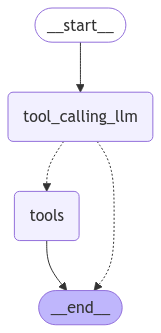

In [18]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([subtract,multiply,add]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

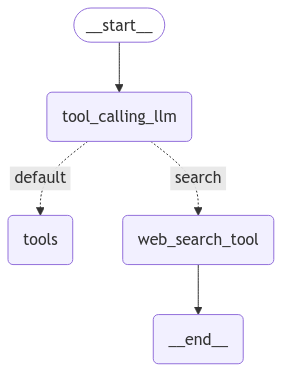

In [32]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults

# Initialize tools
web_search_tool = TavilySearchResults(max_results=1)

# Define condition function
def web_search_condition(state):
    """Return condition based on query content."""
    message_content = state["messages"][-1].content.lower()
    return "search" if "cricket" in message_content or "search" in message_content else "default"

# Set up the graph builder
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([subtract, multiply, add]))
builder.add_node("web_search_tool", ToolNode([web_search_tool]))

# Add the entry point
builder.add_edge(START, "tool_calling_llm")

# Add conditional routing edges
builder.add_conditional_edges(
    "tool_calling_llm",
    web_search_condition,
    {
        "search": "web_search_tool",
        "default": "tools"
    }
)

# Ensure web search node leads to END
builder.add_edge("web_search_tool", END)

# Compile the graph
graph = builder.compile()


# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
from langchain_core.messages import HumanMessage

# Example test input
messages = [HumanMessage(content="Search for cricket updates")]
result = graph.invoke({"messages": messages})

# Display output
for msg in result['messages']:
    msg.pretty_print()

================================ Human Message =================================

Search for cricket updates
================================== Ai Message ==================================

I can't perform a search for cricket updates, but I can suggest some possible sources for cricket news and updates. Would you like me to provide some options?


In [35]:
messages = [HumanMessage(content="what is 2+3*2")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2+3*2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_w81v)
 Call ID: call_w81v
  Args:
    a: 3
    b: 2
  add (call_p7xb)
 Call ID: call_p7xb
  Args:
    a: 2
    b: 6
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: add

8


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`.

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.